# Multi-period OPF example

Re-create PyPower case from CSV files

In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import nygrid.nygrid as ng_grid
import nygrid.run_nygrid as ng_run
import nygrid.plots as ng_plots

In [2]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

grid_data_dir = os.path.join(data_dir, 'grid', '2030CLCPA')
if not os.path.exists(grid_data_dir):
    raise FileNotFoundError('Grid data directory not found.')

print('Grid data directory: {}'.format(grid_data_dir))

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))

results_dir = os.path.join(os.path.dirname(data_dir), 'results')
print('Results directory: {}'.format(results_dir))

renewable_data_dir = os.path.join(data_dir, 'renewable')
print('Renewable data directory: {}'.format(renewable_data_dir))

load_data_dir = os.path.join(data_dir, 'load')
print('Load data directory: {}'.format(load_data_dir))

Grid data directory: /mnt/Bo_HDD/NYgrid-python/data/grid/2030CLCPA
Figure directory: /mnt/Bo_HDD/NYgrid-python/figures
Results directory: /mnt/Bo_HDD/NYgrid-python/results
Renewable data directory: /mnt/Bo_HDD/NYgrid-python/data/renewable
Load data directory: /mnt/Bo_HDD/NYgrid-python/data/load


## Read grid data

### Read generator profiles

In [3]:
start_date = datetime(2018, 1, 1, 0, 0, 0)
end_date = datetime(2018, 12, 31, 0, 0, 0)
timestamp_list = pd.date_range(start_date, end_date, freq='1D')
verbose = True

In [4]:
# Read grid property file
grid_prop = ng_run.read_grid_prop(grid_data_dir)

# Read load and generation profiles
grid_profile = ng_run.read_grid_profile(grid_data_dir, start_date.year)

In [5]:
grid_profile['load_profile'].sum(axis=1).sort_values(ascending=False)

TimeStamp
2018-08-29 16:00:00    93203.379573
2018-08-29 15:00:00    93195.481205
2018-08-28 16:00:00    93096.897866
2018-08-28 17:00:00    92926.644148
2018-08-29 14:00:00    92834.789049
                           ...     
2018-05-13 05:00:00    35697.114653
2018-10-14 04:00:00    35637.438092
2018-05-14 03:00:00    35606.429683
2018-05-13 03:00:00    35419.794164
2018-05-13 04:00:00    35330.279322
Length: 8760, dtype: float64

### Read variable renewable energy (VRE) data

In [6]:
solar_data_dir = os.path.join(data_dir, 'renewable', 'solar')
print('Solar data directory: {}'.format(solar_data_dir))

onshore_wind_data_dir = os.path.join(data_dir, 'renewable', 'onshore_wind')
print('Onshore wind data directory: {}'.format(onshore_wind_data_dir))

offshore_wind_data_dir = os.path.join(data_dir, 'renewable', 'offshore_wind')
print('Offshore wind data directory: {}'.format(offshore_wind_data_dir))

vre_prop, genmax_profile_vre = ng_run.read_vre_data(solar_data_dir,
                                                    onshore_wind_data_dir,

                                                    offshore_wind_data_dir)
grid_prop['vre_prop'] = vre_prop
grid_profile['genmax_profile_vre'] = genmax_profile_vre
# NOTE: Make datetime index consistent
grid_profile['genmax_profile_vre'].index = grid_profile['genmax_profile'].index

Solar data directory: /mnt/Bo_HDD/NYgrid-python/data/renewable/solar
Onshore wind data directory: /mnt/Bo_HDD/NYgrid-python/data/renewable/onshore_wind
Offshore wind data directory: /mnt/Bo_HDD/NYgrid-python/data/renewable/offshore_wind


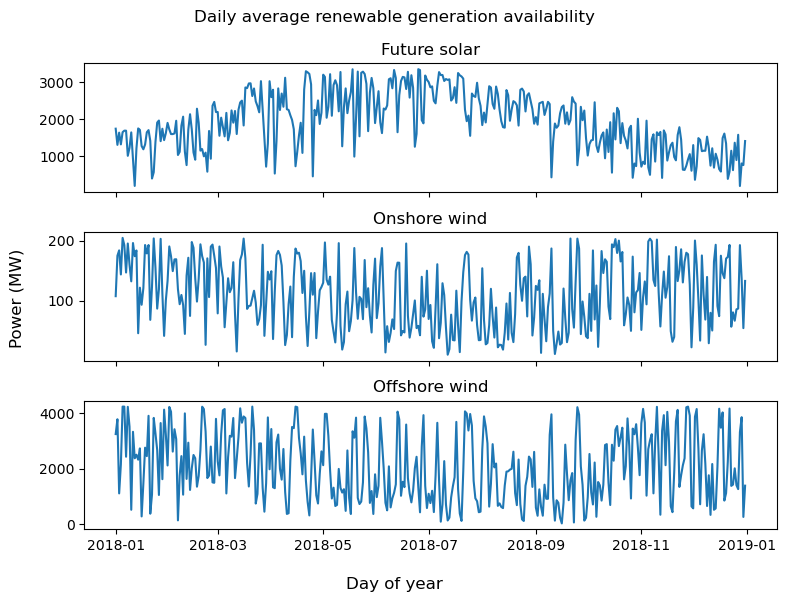

In [7]:
# Aggregate renewable generation
genmax_profile_future_solar = genmax_profile_vre.loc[:,
                                                     genmax_profile_vre.columns.str.contains('FutSol')]
genmax_sum_future_solar = genmax_profile_future_solar.sum(axis=1)
genmax_profile_onshore_wind = genmax_profile_vre.loc[:,
                                                     genmax_profile_vre.columns.str.contains('OnWind')]
genmax_sum_onshore_wind = genmax_profile_onshore_wind.sum(axis=1)
genmax_profile_offshore_wind = genmax_profile_vre.loc[:,
                                                      genmax_profile_vre.columns.str.contains('OffWind')]
genmax_sum_offshore_wind = genmax_profile_offshore_wind.sum(axis=1)

# Plot generation renewable availability
fig, axs = plt.subplots(3, 1, figsize=(8, 6),
                        sharex='all')
axs[0].plot(genmax_sum_future_solar.resample('D').mean(), label='Future solar')
axs[1].plot(genmax_sum_onshore_wind.resample('D').mean(), label='Onshore wind')
axs[2].plot(genmax_sum_offshore_wind.resample(
    'D').mean(), label='Offshore wind')

titles = ['Future solar', 'Onshore wind', 'Offshore wind']

for i, ax in enumerate(axs):
    ax.set_title(titles[i])

fig.supxlabel('Day of year')
fig.supylabel('Power (MW)')
fig.suptitle('Daily average renewable generation availability')
fig.tight_layout()

### Update load profile for electrification

In [8]:
res_building_data_dir = os.path.join(data_dir, 'load', 'residential_building')
print('Residential buildings data directory: {}'.format(res_building_data_dir))

com_building_data_dir = os.path.join(data_dir, 'load', 'commercial_building')
print('Commercial buildings data directory: {}'.format(com_building_data_dir))

electric_vehicle_data_dir = os.path.join(data_dir, 'load', 'electric_vehicle')
print('Electric vehicle data directory: {}'.format(electric_vehicle_data_dir))

# Read NYS county attributes and county to bus mapping
county_attrs = pd.read_csv(os.path.join(
    load_data_dir, 'county_attributes.csv'))
county_2_bus = pd.read_csv(os.path.join(load_data_dir, 'county_2_bus.csv'))

Residential buildings data directory: /mnt/Bo_HDD/NYgrid-python/data/load/residential_building
Commercial buildings data directory: /mnt/Bo_HDD/NYgrid-python/data/load/commercial_building
Electric vehicle data directory: /mnt/Bo_HDD/NYgrid-python/data/load/electric_vehicle


In [9]:
electrification_dict = {
    'res_building': {
        'data_dir': res_building_data_dir,
        'upgrade_id': 10,
        'scaling_factor': 0.3
    },
    'com_building': {
        'data_dir': com_building_data_dir,
        'upgrade_id': 18,
        'scaling_factor': 0.3
    },
    'electric_vehicle': {
        'data_dir': electric_vehicle_data_dir,
        'upgrade_id': 0,
        'scaling_factor': 0.3
    }
}

In [10]:
electrification_dict = ng_run.read_electrification_data(electrification_dict,
                                                        county_attrs,
                                                        county_2_bus)

Get electrification data for 3 sectors:
['res_building', 'com_building', 'electric_vehicle']
Processing res_building electrification data...
Building load data is not available for county G3600030 Single-Family Attached. Skipping...
Building load data is not available for county G3600170 Single-Family Attached. Skipping...
Building load data is not available for county G3600230 Single-Family Attached. Skipping...
Building load data is not available for county G3600490 Single-Family Attached. Skipping...
Building load data is not available for county G3600510 Single-Family Attached. Skipping...
Building load data is not available for county G3600950 Single-Family Attached. Skipping...
Building load data is not available for county G3600970 Multi-Family with 5+ Units. Skipping...
Processing com_building electrification data...
Building load data is not available for county G3600010 Hospital. Skipping...
Building load data is not available for county G3600030 Outpatient. Skipping...
Build

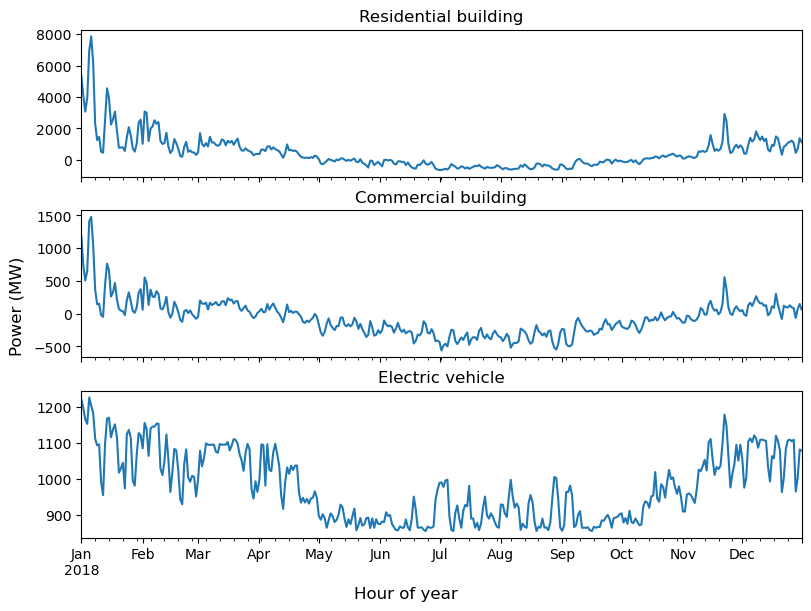

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6),
                        sharex='all', layout='constrained')

res_building_profile = electrification_dict['res_building']['load_change'] * \
    electrification_dict['res_building']['scaling_factor']
com_building_profile = electrification_dict['com_building']['load_change'] * \
    electrification_dict['com_building']['scaling_factor']
electric_vehicle_profile = electrification_dict['electric_vehicle']['load_change'] * \
    electrification_dict['electric_vehicle']['scaling_factor']

res_building_profile.sum(axis=1).resample('D').mean().plot(ax=axs[0])
com_building_profile.sum(axis=1).resample('D').mean().plot(ax=axs[1])
electric_vehicle_profile.sum(axis=1).resample('D').mean().plot(ax=axs[2])

titles = ['Residential building', 'Commercial building', 'Electric vehicle']

for i, ax in enumerate(axs):
    ax.set_title(titles[i])

fig.supxlabel('Hour of year')
fig.supylabel('Power (MW)')
plt.show()

In [12]:
load_profile_elec = grid_profile['load_profile'].copy()

for sector, attrs in electrification_dict.items():
    load_change = attrs['load_change'] * attrs['scaling_factor']
    load_profile_elec = load_profile_elec.add(load_change, fill_value=0)

load_profile_elec = load_profile_elec.sort_index(axis=1)
load_profile_elec = load_profile_elec.round(2)
grid_profile['load_profile'] = load_profile_elec

In [13]:
load_profile_elec.sum(axis=1).sort_values(ascending=False)

TimeStamp
2018-08-28 17:00:00    93614.31
2018-08-29 16:00:00    93385.02
2018-08-28 16:00:00    93301.54
2018-08-29 17:00:00    93101.91
2018-08-29 15:00:00    92968.41
                         ...   
2018-05-13 05:00:00    36070.49
2018-10-14 04:00:00    36049.11
2018-05-14 03:00:00    35965.54
2018-05-13 03:00:00    35862.49
2018-05-13 04:00:00    35685.64
Length: 8760, dtype: float64

## Multi-period OPF

### Without initial conditions

In [14]:
# Only run for one day
d = 240
start_datetime_0 = timestamp_list[d]
end_datetime_0 = start_datetime_0 + timedelta(hours=47)
print(f'Start time: {start_datetime_0}')
print(f'End time: {end_datetime_0}')

Start time: 2018-08-29 00:00:00
End time: 2018-08-30 23:00:00


In [15]:
# 2 nuclear generators are retired
indian_point_names = [
    'Nuclear_H_0_0',  # Gen232
    'Nuclear_H_1_0'  # Gen233
]

# 11 gas turbines are retired due to Peaker rule
retire_peaker_names = [
    "Brentwood",  # Gen57
    "Gowanus 5",  # Gen128
    "Gowanus 6",  # Gen129
    "Harlem River 1",  # Gen132
    "Harlem River 2",  # Gen133
    "Hellgate 1",  # Gen134
    "Hellgate 2",  # Gen135
    "Kent",  # Gen159
    "Pouch",  # Gen195
    "Vernon Blvd 2",  # Gen222
    "Vernon Blvd 3",  # Gen223
]

# Remaining number of generators is 303 - 2 - 11 = 290

In [16]:
# Create NYGrid object
nygrid_sim_0 = ng_grid.NYGrid(grid_prop=grid_prop,
                              start_datetime=start_datetime_0,
                              end_datetime=end_datetime_0,
                              verbose=verbose)

# Set load and generation time series data
nygrid_sim_0.set_load_sch(grid_profile['load_profile'])
nygrid_sim_0.set_gen_mw_sch(grid_profile['gen_profile'])
nygrid_sim_0.set_gen_max_sch(grid_profile['genmax_profile'])
nygrid_sim_0.set_gen_min_sch(grid_profile['genmin_profile'])
nygrid_sim_0.set_gen_ramp_sch(grid_profile['genramp30_profile'])
nygrid_sim_0.set_gen_cost_sch(grid_profile['gencost0_profile'],
                              grid_profile['gencost1_profile'])

if 'genmax_profile_vre' in grid_profile:
    nygrid_sim_0.set_vre_max_sch(grid_profile['genmax_profile_vre'])

# Relax branch flow limits
nygrid_sim_0.relax_external_branch_lim()

# Set generator initial condition
nygrid_sim_0.set_gen_init_data(gen_init=None)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    # 'PenaltyForBranchMwViolation': 5_000,
    # 'PenaltyForInterfaceMWViolation': 5_000
}

nygrid_sim_0.set_options(options)

# Solve DC OPF
nygrid_sim_0.solve_dc_opf()

# Get results
results_0 = nygrid_sim_0.get_results_dc_opf()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmpbpxkw82_.pyomo.lp
Reading time = 0.31 seconds
x1: 105450 rows, 91009 columns, 466080 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 105450 rows, 91009 columns and 466080 nonzeros
Model fingerprint: 0x38ddaac0
Coefficient statistics:
  Matrix range     [3e-06, 2e+00]
  Objective range  [5e-01, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-07, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 91373 rows and 64220 columns
Presolve time: 0.18s
Presolved: 14077 rows, 26789 columns, 94333 nonzeros

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 7.392e+04
 Factor NZ  : 3.613e+05 (

In [17]:
print("s_ramp_up", results_0['s_ramp_up'].sum())
print("s_ramp_down", results_0['s_ramp_down'].sum())
print("s_over_gen", results_0['s_over_gen'].sum())
print("s_load_shed", results_0['s_load_shed'].sum())
print("s_if_max", results_0['s_if_max'].sum())
print("s_if_min", results_0['s_if_min'].sum())
print("s_br_max", results_0['s_br_max'].sum())
print("s_br_min", results_0['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 252328.5685833727
s_if_min 9204.811900034989
s_br_max 0.0
s_br_min 0.0


### With initial conditions

In [18]:
# Only run for one day
d = d+1
start_datetime_1 = timestamp_list[d]
end_datetime_1 = start_datetime_1 + timedelta(hours=47)
print(f'Start time: {start_datetime_1}')
print(f'End time: {end_datetime_1}')

Start time: 2018-08-30 00:00:00
End time: 2018-08-31 23:00:00


In [19]:
# Create NYGrid object
nygrid_sim_1 = ng_grid.NYGrid(grid_prop=grid_prop,
                              start_datetime=start_datetime_1,
                              end_datetime=end_datetime_1,
                              verbose=verbose)

# Set load and generation time series data
nygrid_sim_1.set_load_sch(grid_profile['load_profile'])
nygrid_sim_1.set_gen_mw_sch(grid_profile['gen_profile'])
nygrid_sim_1.set_gen_max_sch(grid_profile['genmax_profile'])
nygrid_sim_1.set_gen_min_sch(grid_profile['genmin_profile'])
nygrid_sim_1.set_gen_ramp_sch(grid_profile['genramp30_profile'])
nygrid_sim_1.set_gen_cost_sch(grid_profile['gencost0_profile'],
                              grid_profile['gencost1_profile'])

if 'genmax_profile_vre' in grid_profile:
    nygrid_sim_1.set_vre_max_sch(grid_profile['genmax_profile_vre'])

# Relax branch flow limits
nygrid_sim_1.relax_external_branch_lim()

# Set generator initial condition
last_gen = results_0['PG'].loc[start_datetime_1].to_numpy().squeeze()
nygrid_sim_1.set_gen_init_data(gen_init=last_gen)

# Set ESR initial condition for the next iteration
last_soc = results_0['esrSOC'].loc[start_datetime_1].to_numpy().squeeze()
nygrid_sim_1.set_esr_init_data(esr_init=last_soc)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    # 'PenaltyForBranchMwViolation': 10_000,
    # 'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_1.set_options(options)

# Solve DC OPF
nygrid_sim_1.solve_dc_opf()

# Get results
results_1 = nygrid_sim_1.get_results_dc_opf()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmpnakmg_mm.pyomo.lp
Reading time = 0.31 seconds
x1: 106254 rows, 91009 columns, 467688 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 106254 rows, 91009 columns and 467688 nonzeros
Model fingerprint: 0x9e1f4090
Coefficient statistics:
  Matrix range     [3e-06, 2e+00]
  Objective range  [5e-01, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-07, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 92328 rows and 64394 columns
Presolve time: 0.18s
Presolved: 13926 rows, 26615 columns, 91951 nonzeros

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 7.029e+04
 Factor NZ  : 3.507e+05 (

In [20]:
print("s_ramp_up", results_1['s_ramp_up'].sum())
print("s_ramp_down", results_1['s_ramp_down'].sum())
print("s_over_gen", results_1['s_over_gen'].sum())
print("s_load_shed", results_1['s_load_shed'].sum())
print("s_if_max", results_1['s_if_max'].sum())
print("s_if_min", results_1['s_if_min'].sum())
print("s_br_max", results_1['s_br_max'].sum())
print("s_br_min", results_1['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 131789.41068538112
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


## Process the results

### Costs

In [21]:
print(f'Total cost: {results_0["total_cost"].sum():.2f}')
print(f'Gen cost: {results_0["gen_cost"].sum():.2f}')
print(
    f'Over generation penalty: {results_0["over_gen_penalty"].sum():.2f}')
print(f'Load shed penalty: {results_0["load_shed_penalty"].sum():.2f}')
print(f'Ramp up penalty: {results_0["ramp_up_penalty"].sum():.2f}')
print(f'Ramp down penalty: {results_0["ramp_down_penalty"].sum():.2f}')
print(
    f'Interface max penalty: {results_0["if_max_penalty"].sum():.2f}')
print(
    f'Interface min penalty: {results_0["if_min_penalty"].sum():.2f}')
print(f'Branch max penalty: {results_0["br_max_penalty"].sum():.2f}')
print(f'Branch min penalty: {results_0["br_min_penalty"].sum():.2f}')

Total cost: 365104066.50
Gen cost: 103570188.36
Over generation penalty: 0.00
Load shed penalty: 0.00
Ramp up penalty: 0.00
Ramp down penalty: 0.00
Interface max penalty: 252328568.58
Interface min penalty: 9204811.90
Branch max penalty: 0.00
Branch min penalty: 0.00


In [22]:
print(f'Total cost: {results_1["total_cost"].sum():.2f}')
print(f'Gen cost: {results_1["gen_cost"].sum():.2f}')
print(
    f'Over generation penalty: {results_1["over_gen_penalty"].sum():.2f}')
print(f'Load shed penalty: {results_1["load_shed_penalty"].sum():.2f}')
print(f'Ramp up penalty: {results_1["ramp_up_penalty"].sum():.2f}')
print(f'Ramp down penalty: {results_1["ramp_down_penalty"].sum():.2f}')
print(
    f'Interface max penalty: {results_1["if_max_penalty"].sum():.2f}')
print(
    f'Interface min penalty: {results_1["if_min_penalty"].sum():.2f}')
print(f'Branch max penalty: {results_1["br_max_penalty"].sum():.2f}')
print(f'Branch min penalty: {results_1["br_min_penalty"].sum():.2f}')

Total cost: 206824572.65
Gen cost: 75034798.92
Over generation penalty: 0.00
Load shed penalty: 0.00
Ramp up penalty: 0.00
Ramp down penalty: 0.00
Interface max penalty: 131789410.69
Interface min penalty: 0.00
Branch max penalty: 0.00
Branch min penalty: 0.00


### LMP

In [23]:
# Create a dict where key is busIdx and value is zoneID
bus_zone_alloc = nygrid_sim_0.grid_prop['bus_prop'].set_index(
    'BUS_I').to_dict()['BUS_ZONE']
bus_names = list(bus_zone_alloc.keys())
bus_names_str = [f'Bus{i}' for i in bus_names]

In [24]:
lmp_0 = results_0['LMP']
lmp_0.columns = bus_names

# Aggregate LMPs by zone
lmp_0_zone = lmp_0.T.groupby(bus_zone_alloc).mean().T

lmp_1 = results_1['LMP']
lmp_1.columns = bus_names

# Aggregate LMPs by zone
lmp_1_zone = lmp_1.T.groupby(bus_zone_alloc).mean().T

Text(0.5, 0.98, 'Day 1 w/o IC')

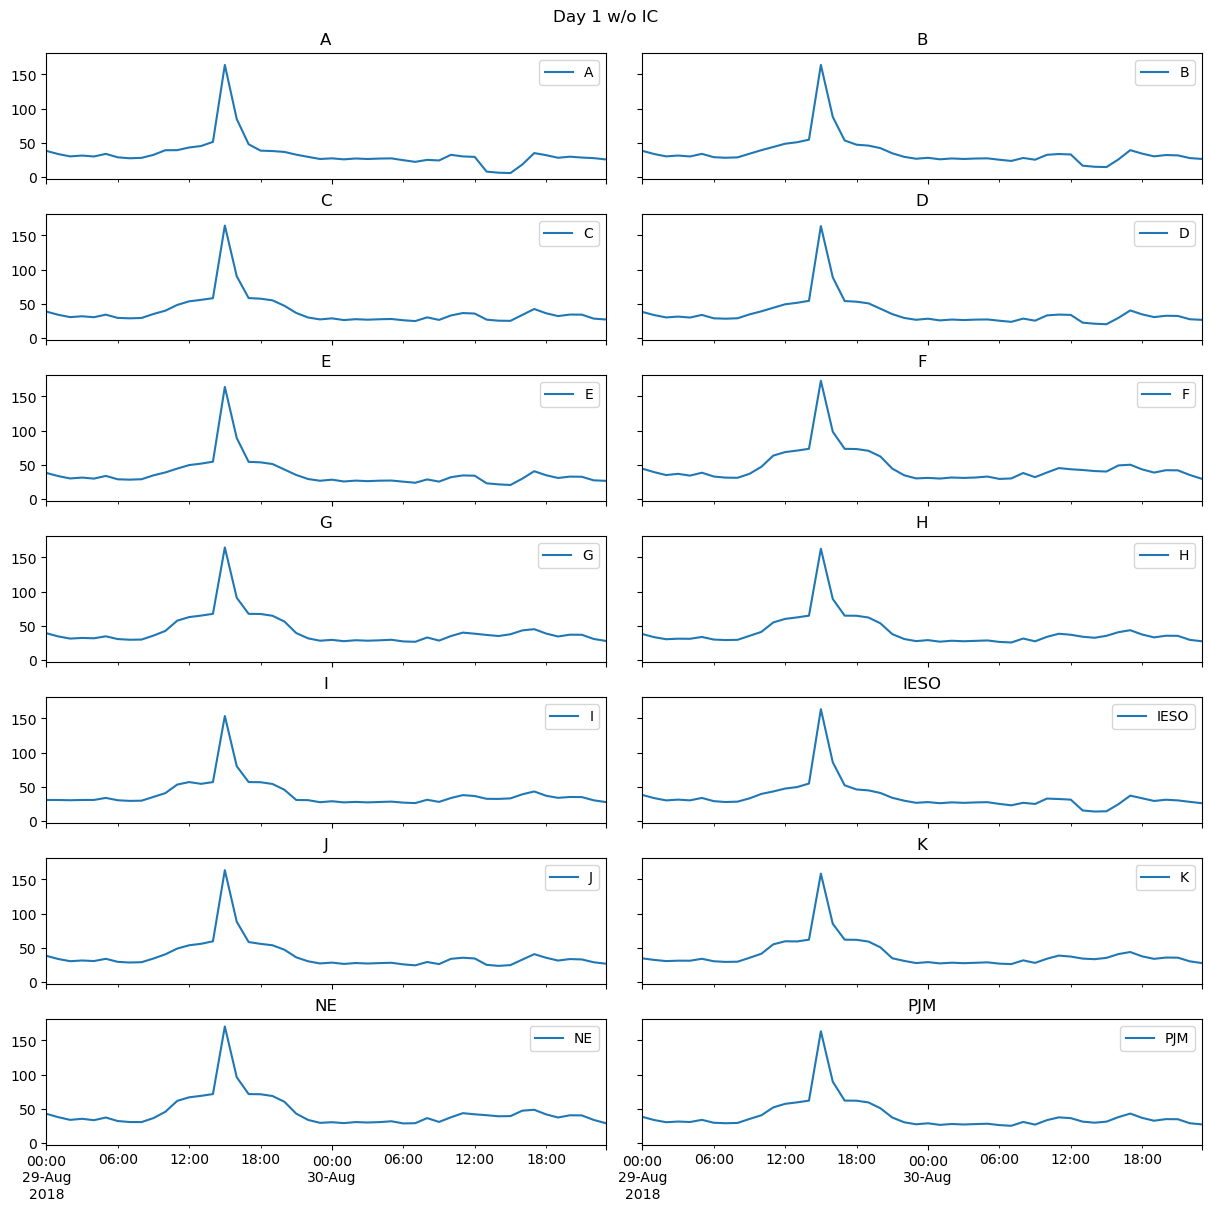

In [25]:
fig, axs = plt.subplots(7, 2, figsize=(12, 12), 
                        sharex='all', sharey='all',
                        layout='constrained')
# Plot LMPs w/o ESR
for i, ax in enumerate(axs.flat):
    lmp_0_zone.iloc[:, i].plot(ax=ax)
    ax.set_title(lmp_0_zone.columns[i])
    ax.legend()
fig.suptitle('Day 1 w/o IC')

Text(0.5, 0.98, 'Day 2 w/ IC')

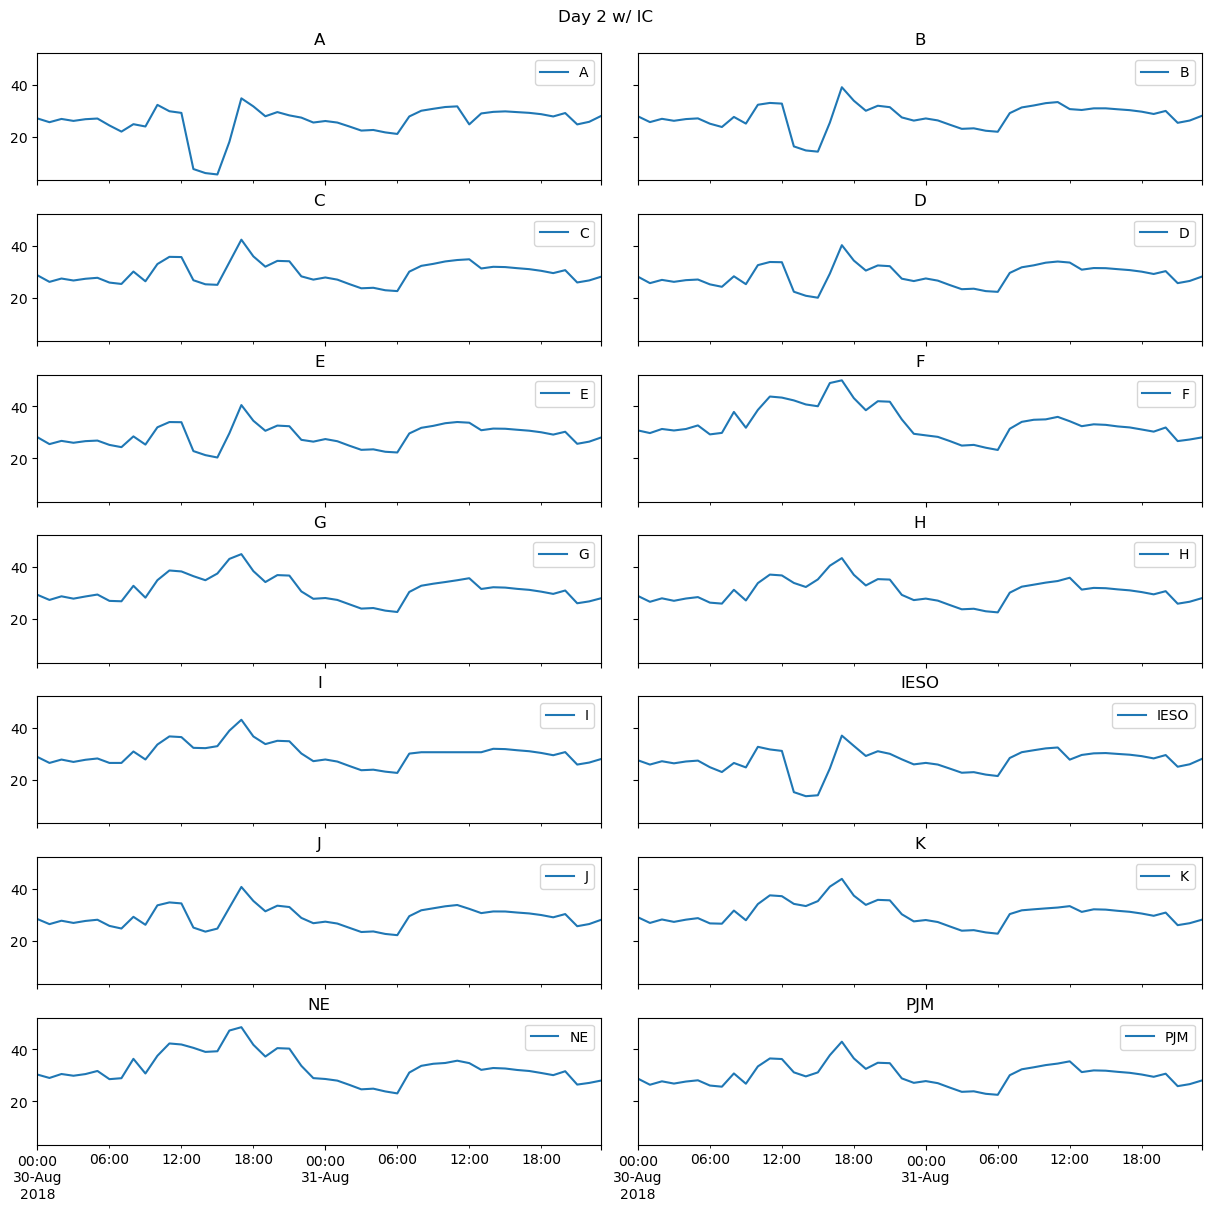

In [26]:
fig, axs = plt.subplots(7, 2, figsize=(12, 12), 
                        sharex='all', sharey='all',
                        layout='constrained')
# Plot LMPs w/o ESR
for i, ax in enumerate(axs.flat):
    lmp_1_zone.iloc[:, i].plot(ax=ax)
    ax.set_title(lmp_1_zone.columns[i])
    ax.legend()
fig.suptitle('Day 2 w/ IC')

### ESR

In [27]:
ii = 6
crg_max = grid_prop['esr_prop']['ESR_CRG_MAX'].iloc[ii]
dis_max = grid_prop['esr_prop']['ESR_DIS_MAX'].iloc[ii]
crg_eff = grid_prop['esr_prop']['ESR_CRG_EFF'].iloc[ii]
dis_eff = grid_prop['esr_prop']['ESR_DIS_EFF'].iloc[ii]
soc_init = grid_prop['esr_prop']['ESR_SOC_INI'].iloc[ii]
soc_max = grid_prop['esr_prop']['ESR_SOC_MAX'].iloc[ii]

print(f'crg_max: {crg_max}, dis_max: {dis_max}, crg_eff: {crg_eff}, dis_eff: {dis_eff}, soc_init: {soc_init}, soc_max: {soc_max}')


crg_max: 2.0, dis_max: 2.0, crg_eff: 0.85, dis_eff: 0.85, soc_init: 4, soc_max: 8


Text(0.5, 0.98, 'Day 1 w/o IC')

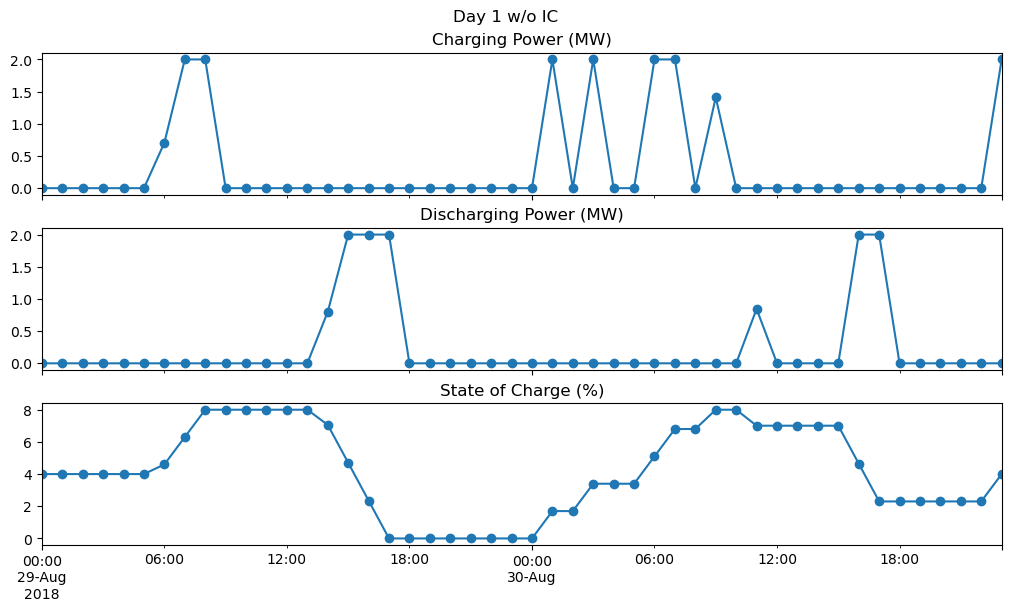

In [28]:
fig, ax = plt.subplots(3, 1, figsize=(10, 6),
                       sharex=True, layout='constrained')

results_0['esrPCrg'].iloc[:, ii].plot(title='Charging Power (MW)',
                                            ax=ax[0], marker='o')
results_0['esrPDis'].iloc[:, ii].plot(title='Discharging Power (MW)',
                                            ax=ax[1], marker='o')
results_0['esrSOC'].iloc[:, ii].plot(title='State of Charge (%)',
                                           ax=ax[2], marker='o')
fig.suptitle('Day 1 w/o IC')

Text(0.5, 0.98, 'Day 2 w/ IC')

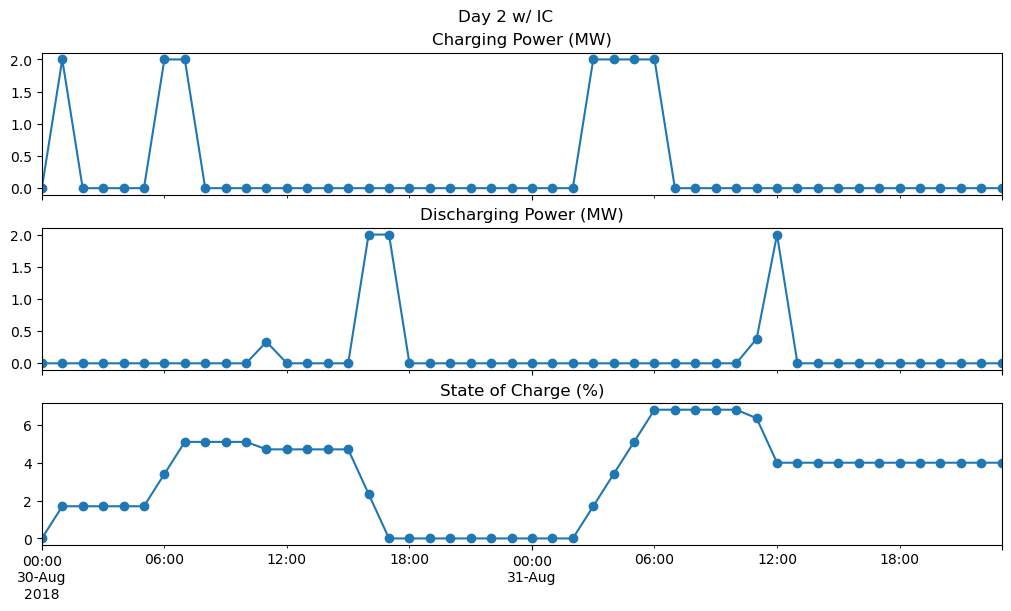

In [29]:
fig, ax = plt.subplots(3, 1, figsize=(10, 6),
                       sharex=True, layout='constrained')

results_1['esrPCrg'].iloc[:, ii].plot(title='Charging Power (MW)',
                                            ax=ax[0], marker='o')
results_1['esrPDis'].iloc[:, ii].plot(title='Discharging Power (MW)',
                                            ax=ax[1], marker='o')
results_1['esrSOC'].iloc[:, ii].plot(title='State of Charge (%)',
                                           ax=ax[2], marker='o')
fig.suptitle('Day 2 w/ IC')

### Thermal generation

In [30]:
# Read thermal generator info table
filename = os.path.join(grid_data_dir, 'genInfo.csv')
gen_info = pd.read_csv(filename)
num_thermal = gen_info.shape[0]
gen_rename = {gen_info.index[i]: gen_info.NYISOName[i]
              for i in range(num_thermal)}
gen_info

,NYISOName,PTID,Zone,UnitType,FuelType,Latitude,Longitude,maxPower,minPower,maxRampAgc,...,maxRamp60,HeatRateLM_1,HeatRateLM_0,HeatRateLM_R2,HeatRateQM_2,HeatRateQM_1,HeatRateQM_0,HeatRateQM_R2,useQM,start-time
0,59 St. GT 1,24138,J,Combustion Turbine,Kerosene,40.772385,-73.993028,17.1,0.0,1.710000,...,17.1,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
1,74 St. GT 1,24260,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
2,74 St. GT 2,24261,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
3,Allegany,23514,B,Combined Cycle,Natural Gas,42.508300,-78.066100,66.0,11.0,6.600000,...,66.0,8.218122,-14.577671,0.862443,-0.094773,15.209040,-125.857658,0.891407,1,10m
4,Allied Frozen Storage,23774,A,Internal Combustion,Natural Gas,42.842029,-78.722673,0.1,0.0,0.010000,...,0.1,8.899000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Vernon Blvd 3,24163,J,Combustion Turbine,Natural Gas,40.753900,-73.950600,42.0,15.0,0.558333,...,33.5,17.272897,-319.572736,0.893510,0.524043,-14.979198,132.238854,0.935802,1,over
223,Wading River 1,23522,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,102.0,9.0,1.258333,...,75.5,12.779330,-5.232355,0.960069,-0.051615,18.026301,-96.225639,0.967170,1,over
224,Wading River 2,23547,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,7.8,1.350000,...,81.0,13.381103,-32.778267,0.981323,-0.027035,15.957351,-73.206752,0.982889,1,over
225,Wading River 3,23601,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,4.0,1.333333,...,80.0,12.154083,-11.601042,0.822005,-0.022269,14.190789,-39.250293,0.821057,1,over


In [31]:
# Format results
thermal_pg_0 = (results_0['PG'].iloc[:, :num_thermal]
                       .rename(columns=gen_rename))

thermal_pg_1 = (results_1['PG'].iloc[:, :num_thermal]
                       .rename(columns=gen_rename))

NYISOName              Allegany
PTID                      23514
Zone                          B
UnitType         Combined Cycle
FuelType            Natural Gas
Latitude                42.5083
Longitude              -78.0661
maxPower                   66.0
minPower                   11.0
maxRampAgc                  6.6
maxRamp10                  66.0
maxRamp30                  66.0
maxRamp60                  66.0
HeatRateLM_1           8.218122
HeatRateLM_0         -14.577671
HeatRateLM_R2          0.862443
HeatRateQM_2          -0.094773
HeatRateQM_1           15.20904
HeatRateQM_0        -125.857658
HeatRateQM_R2          0.891407
useQM                         1
start-time                  10m
Name: 3, dtype: object

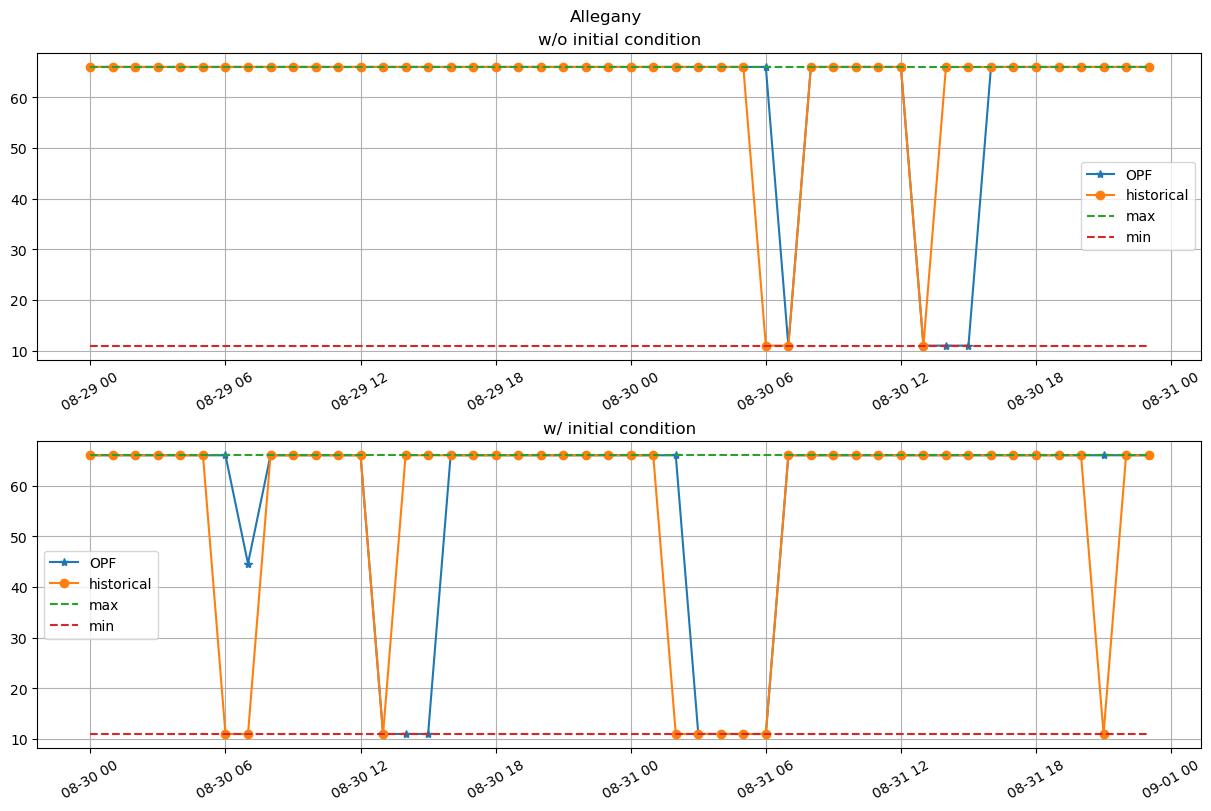

In [32]:
ii = 3
display(gen_info.iloc[ii, :])

fig, axs = plt.subplots(2, 1, figsize=(12, 8), layout='constrained')

axs[0] = ng_plots.plot_gen(thermal_pg_0.iloc[:, ii],
                           grid_profile['gen_profile'][start_datetime_0:end_datetime_0].iloc[:, ii],
                           grid_profile['genmax_profile'][start_datetime_0:end_datetime_0].iloc[:, ii],
                           grid_profile['genmin_profile'][start_datetime_0:end_datetime_0].iloc[:, ii],
                           ax=axs[0], title="w/o initial condition")

axs[1] = ng_plots.plot_gen(thermal_pg_1.iloc[:, ii],
                           grid_profile['gen_profile'][start_datetime_1:end_datetime_1].iloc[:, ii],
                           grid_profile['genmax_profile'][start_datetime_1:end_datetime_1].iloc[:, ii],
                           grid_profile['genmin_profile'][start_datetime_1:end_datetime_1].iloc[:, ii],
                           ax=axs[1], title="w/ initial condition")

for ax in axs.flat:
    ax.tick_params(axis='x', rotation=30)
    ax.grid()

fig.suptitle(f'{gen_info.NYISOName[ii]}')
fig.show()